In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import ast
import json
import numpy as np
import os
import re
from sklearn.linear_model import LinearRegression

In [3]:
megatron_name_to_crfm_name_mapping = {
    "gptj_6b": ["huggingface/gptj_6b", "gooseai/gpt-j-6b", "together/gpt-j-6b"],
    "gpt_neox_20b": ["gooseai/gpt-neo-20b", "together/gpt-neox-20b"],
    "openai_ada": ["openai/ada"],
    "openai_davinci": ["openai/davinci", "together/opt-175b"],
    "ai21_j1_large": ["ai21/j1-large", "openai/curie", "microsoft/TNLGv2_7B"],
    "ai21_j1_grande": ["ai21/j1-grande"],
    "ai21_j1_jumbo": ["ai21/j1-jumbo"],
    "gpt2": ["huggingface/gpt2"],
    "mt_nlg": ["microsoft/TNLGv2_530B"],
    "anthropic": ["anthropic/stanford-online-all-v4-s3"],
    "bloom": ["together/bloom"],
    "opt_66b": ["together/opt-66b"],
    "yalm": ["together/yalm"],
}

crfm_name_to_megatron_name_mapping = {}
for megatron_name in megatron_name_to_crfm_name_mapping:
    crfm_names = megatron_name_to_crfm_name_mapping[megatron_name]
    crfm_name = crfm_names[0]
    crfm_name_to_megatron_name_mapping[
        crfm_name.replace("/", "_")] = megatron_name
crfm_name_to_megatron_name_mapping["together_opt-175b"] = "opt_175b"
crfm_name_to_megatron_name_mapping["together_gpt-neo-20b"] = "together_gpt_neox_20b"
crfm_name_to_megatron_name_mapping["together_gpt-j-6b"] = "together_gptj_6b"

model_parameter_mapping = {
    # (hidden_size, num_layers, gpus).
    "gptj_6b": (4096, 28, 1),
    "gpt_neox_20b": (6144, 44, 1),
    "openai_ada": (1024, 24, 1),
    "openai_davinci": (12288, 96, 8),
    "ai21_j1_large": (4096, 32, 1),
    "openai_curie": (4096, 32, 1),
    "ai21_j1_grande": (6144, 44, 1),  # TODO: This needs to be fixed.
    "ai21_j1_jumbo": (13824, 76, 8),
    "gpt2": (4096, 48, 1),
    "mt_nlg": (20480, 105, 8),
    "anthropic": (8192, 64, 4),
    "bloom": (14336, 70, 8),
    "opt_66b": (9216, 64, 4),
    "yalm": (10240, 80, 4),
}

# Read runtimes from logfiles

In [4]:
def read_megatron_runtimes(logfile_directory):
    runtimes = {}
    for logfile_name in os.listdir(logfile_directory):
        model = logfile_name.replace(".log", "")
        logfile_full_path = os.path.join(logfile_directory, logfile_name)
        with open(logfile_full_path, 'r') as f:
            for line in f:
                m = re.match(r'Runtime for (.*): (\d+\.\d+) seconds', line)
                if m is not None:
                    label = ast.literal_eval(m.group(1))
                    label['model'] = model
                    runtime = float(m.group(2))
                    # Account for the fact that we only profiled 1/3rd of the layers
                    # in the Megatron-Turing NLG model.
                    if model == "mt_nlg":
                        runtime *= 3
                    runtimes[(label['model'], label['num_input_tokens'],
                              label['num_output_tokens'])] = runtime
    return runtimes

In [5]:
megatron_runtimes = read_megatron_runtimes("../logs/a100")

In [6]:
import json
def read_real_system_runtimes(parent_dir):
    all_runtimes = {}
    for sub_dir in os.listdir(parent_dir):
        m = re.match(r'synthetic_efficiency:.*,num_input_tokens=(\d+),'
                     r'num_output_tokens=(\d+),.*,model=(.*)', sub_dir)
        if m is not None:
            num_input_tokens = int(m.group(1))
            num_output_tokens = int(m.group(2))
            model = crfm_name_to_megatron_name_mapping.get(m.group(3), m.group(3))
            
            full_logpath = os.path.join(parent_dir, sub_dir, "per_instance_metrics.json")
            try:
                with open(full_logpath, 'r') as f:
                    metrics = json.load(f)
                    runtimes = []
                    for instance, metrics in metrics.items():
                        for metric in metrics:
                            if metric["name"]["name"] == "inference_runtime":
                                runtimes.append(metric["values"][0])
                    all_runtimes[(model, num_input_tokens, num_output_tokens)] = min(runtimes)
            except:
                pass
        
    return all_runtimes

In [7]:
real_system_runtimes = read_real_system_runtimes("../benchmark_output/runs/latest")

# Plot runtimes versus number of output tokens to verify linearity

In [8]:
def plot_per_model_runtimes(runtimes, model, all_num_input_tokens,
                            scatter=False, runtime_per_output_token=None,
                            ylabel=None,
                            output_filename=None):
    print(model)

    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    markers = ['+', 'D', 's', 'o']
    for marker, num_input_tokens in zip(markers, all_num_input_tokens):
        num_output_tokens_and_runtimes = []
        for label, runtime in runtimes.items():
            if label[0] == model and label[1] == num_input_tokens:
                num_output_tokens_and_runtimes.append((label[2], runtime))
        num_output_tokens_and_runtimes.sort()
        if scatter:
            ax.scatter([x for (x, _) in num_output_tokens_and_runtimes],
                       [y for (_, y) in num_output_tokens_and_runtimes],
                       label=f"{num_input_tokens}",
                       marker=marker)
            if runtime_per_output_token is not None:
                intercept = num_output_tokens_and_runtimes[0][1]
                ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                        [intercept + ((x - 1) * runtime_per_output_token)
                         for (x, _) in num_output_tokens_and_runtimes], linestyle=':')
        else:
            ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                    [y for (_, y) in num_output_tokens_and_runtimes],
                    label=f"{num_input_tokens}",
                    marker='o')
            
    ax.set_xticks([1, 4, 8, 16, 32, 48, 64])
    
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel("Number of output tokens")
    if ylabel is None:
        ax.set_ylabel("Runtime (seconds)")
    else:
        ax.set_ylabel(ylabel)
    plt.legend(frameon=False, ncol=2)
    sns.despine()
    
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    
    plt.show()

# Get best-fit lines (slope and intercept)

In [9]:
import numpy as np

VOCAB_SIZE = 50304

def compute_best_fit(runtimes, models, real_system=False, filename=None):
    json_obj = {}
    runtimes_per_output_token = {}
    for model in models:
        model_obj = {}
        model.replace("-", "_")
        
        # Get all unique num_prompt_tokens.
        all_num_prompt_tokens = set()
        for label in runtimes:
            all_num_prompt_tokens.add(label[1])
        all_num_prompt_tokens = sorted(list(all_num_prompt_tokens))
        
        # Group runtimes by num_prompt_tokens.
        processed_runtimes = [[] for num_prompt_tokens in all_num_prompt_tokens]
        for i, num_prompt_tokens in enumerate(all_num_prompt_tokens):
            for label, runtime in runtimes.items():
                if label[0] == model and label[1] == num_prompt_tokens:
                    processed_runtimes[i].append((label[2], runtime))
            processed_runtimes[i].sort()
                    
        # Cost of embedding num_prompt_tokens is just the runtime when
        # num_output_tokens is equal to 1.
        runtime_for_prompt_tokens = {}
        for i, num_prompt_tokens in enumerate(all_num_prompt_tokens):
            assert processed_runtimes[i][0][0] == 1
            runtime_for_prompt_tokens[num_prompt_tokens] = round(processed_runtimes[i][0][1], 3)
            
        (hidden_size, num_layers, num_gpus_for_model) = model_parameter_mapping[model]

        # Perform regression between adjusted runtimes (end-to-end
        # runtime minus embedding runtime with num_prompt_tokens) and
        # number of output tokens, to obtain the runtime per generated
        # output token.
        num_output_tokens_and_runtimes = []
        for i, num_prompt_tokens in enumerate(all_num_prompt_tokens):
            for label, runtime in runtimes.items():
                if label[0] == model and label[1] == num_prompt_tokens:
                    num_output_tokens_and_runtimes.append(
                        (label[2], runtime - runtime_for_prompt_tokens[num_prompt_tokens]))
        X = [[x] for (x, _) in num_output_tokens_and_runtimes]
        Y = [y for (_, y) in num_output_tokens_and_runtimes]
        reg = LinearRegression()
        reg.fit(X, Y)
        print(f"R^2 score: {reg.score(X, Y):.3f}")
        runtime_per_output_token = round(reg.coef_[0], 3)
        runtimes_per_output_token[model] = runtime_per_output_token
        overhead = round(runtime_for_prompt_tokens[1] - runtime_per_output_token, 3)
        print(f"Overhead: {overhead:.3f} seconds")
        if real_system:
            for num_prompt_tokens in runtime_for_prompt_tokens:
                runtime_for_prompt_tokens[num_prompt_tokens] -= overhead
                runtime_for_prompt_tokens[num_prompt_tokens] = round(
                    runtime_for_prompt_tokens[num_prompt_tokens], 3)

        num_compute_operations = 24 * hidden_size**2 * num_layers
        throughput = num_compute_operations / (
            runtime_per_output_token * 10**12 * num_gpus_for_model)
        print(f"{model}:\n\tRuntime per output token = {runtime_per_output_token:.3f} seconds, "
              f"throughput = {throughput:.3f} TFLOP/s/GPU\n")
        model_obj['runtime_per_output_token'] = runtime_per_output_token
        for i, num_prompt_tokens in enumerate(all_num_prompt_tokens):
            num_compute_operations = \
                24 * num_prompt_tokens * hidden_size**2 * num_layers * (
                1. + (num_prompt_tokens / (6 * hidden_size)) + (
                    VOCAB_SIZE / (16. * num_layers * hidden_size)))
            runtime = runtime_for_prompt_tokens[num_prompt_tokens]
            throughput = num_compute_operations / (
                runtime * 10**12 * num_gpus_for_model)
            print(f"\tRuntime for {num_prompt_tokens} prompt token(s) = {runtime:.3f} seconds, "
                  f"throughput = {throughput:.3f} TFLOP/s/GPU")
        print()
        
        square_errors = []
        for i, num_prompt_tokens in enumerate(all_num_prompt_tokens):
            for label, runtime in runtimes.items():
                if label[0] == model and label[1] == num_prompt_tokens:
                    estimated_runtime = runtime_for_prompt_tokens[num_prompt_tokens] + (
                        (label[2] - 1) * runtime_per_output_token)
                    square_errors.append((runtime - estimated_runtime)**2)
        print(f"\tMean squared error: {np.mean(square_errors):.4f}")
        print(f"\tMaximum squared error: {max(square_errors):.4f}")
        print()

        model_obj['runtime_for_prompt_tokens'] = runtime_for_prompt_tokens
        if real_system:
            model_obj['overhead'] = overhead
        if model in megatron_name_to_crfm_name_mapping:
            model_names = megatron_name_to_crfm_name_mapping[model]
            if real_system:
                model_names = model_names[:1]
            for model_name in model_names:
                json_obj[model_name] = model_obj
    print("=" * 100)
    print()
    
    if filename is not None:
        with open(filename, 'w') as f:
            json.dump(json_obj, f, indent=2)
            
    return runtimes_per_output_token

In [10]:
# Compute best fit for A100 runtimes.
megatron_models = ["openai_ada", "openai_davinci", "ai21_j1_large", "ai21_j1_jumbo",
                   "gptj_6b", "gpt_neox_20b", "mt_nlg", "anthropic", "bloom",
                   "opt_66b", "yalm"]
real_system_models = ["ai21_j1_large", "ai21_j1_grande", "ai21_j1_jumbo"]
megatron_runtimes_per_output_token = \
    compute_best_fit(megatron_runtimes, megatron_models,
                     filename="../processed_jsons/inference_idealized_runtimes.json")
real_system_runtimes_per_output_token = \
    compute_best_fit(real_system_runtimes, real_system_models,
                     real_system=True,
                     filename="../processed_jsons/inference_denoised_runtimes.json")

R^2 score: 1.000
Overhead: 0.001 seconds
openai_ada:
	Runtime per output token = 0.019 seconds, throughput = 0.032 TFLOP/s/GPU

	Runtime for 1 prompt token(s) = 0.020 seconds, throughput = 0.034 TFLOP/s/GPU
	Runtime for 16 prompt token(s) = 0.021 seconds, throughput = 0.520 TFLOP/s/GPU
	Runtime for 32 prompt token(s) = 0.020 seconds, throughput = 1.095 TFLOP/s/GPU
	Runtime for 64 prompt token(s) = 0.020 seconds, throughput = 2.200 TFLOP/s/GPU
	Runtime for 128 prompt token(s) = 0.021 seconds, throughput = 4.229 TFLOP/s/GPU
	Runtime for 192 prompt token(s) = 0.021 seconds, throughput = 6.401 TFLOP/s/GPU
	Runtime for 256 prompt token(s) = 0.022 seconds, throughput = 8.220 TFLOP/s/GPU
	Runtime for 320 prompt token(s) = 0.023 seconds, throughput = 9.916 TFLOP/s/GPU
	Runtime for 384 prompt token(s) = 0.023 seconds, throughput = 12.004 TFLOP/s/GPU
	Runtime for 428 prompt token(s) = 0.024 seconds, throughput = 12.899 TFLOP/s/GPU
	Runtime for 472 prompt token(s) = 0.024 seconds, throughput = 14

openai_davinci


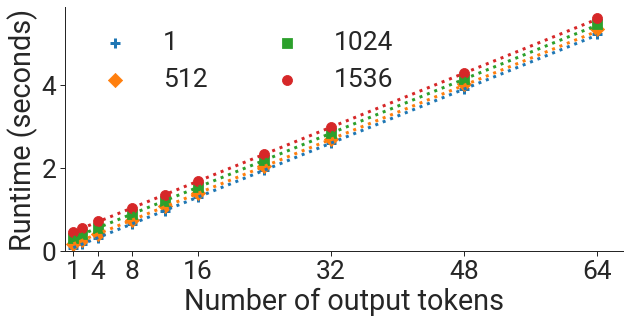

ai21_j1_jumbo


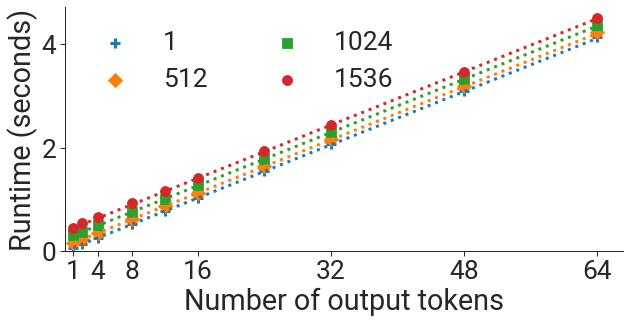

mt_nlg


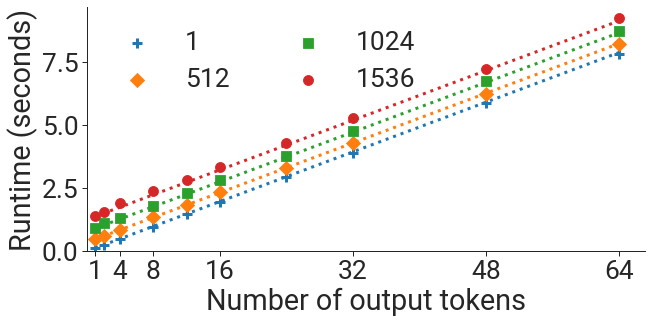

anthropic


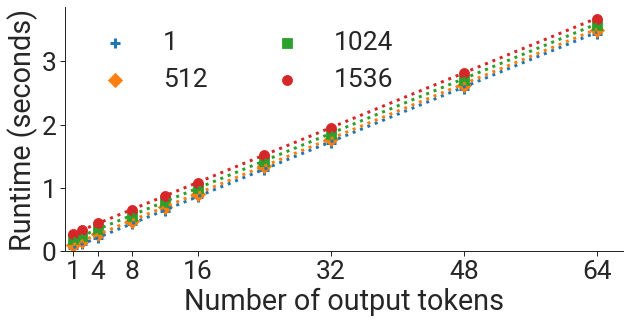

bloom


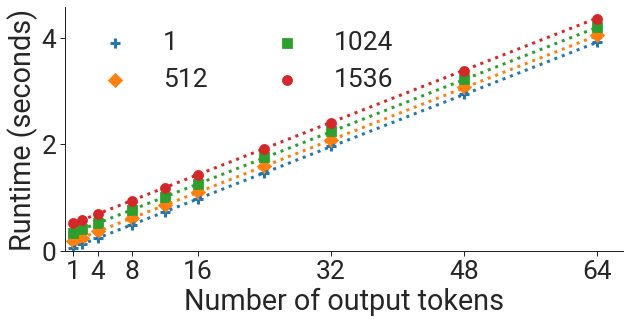

opt_66b


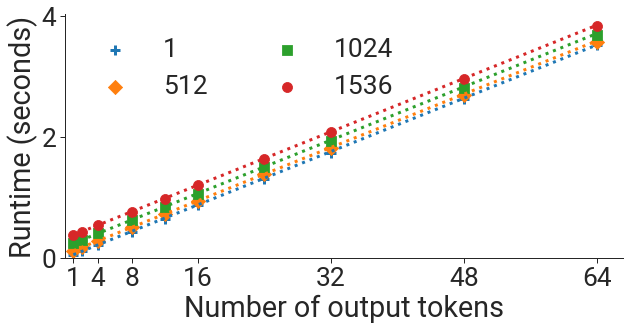

yalm


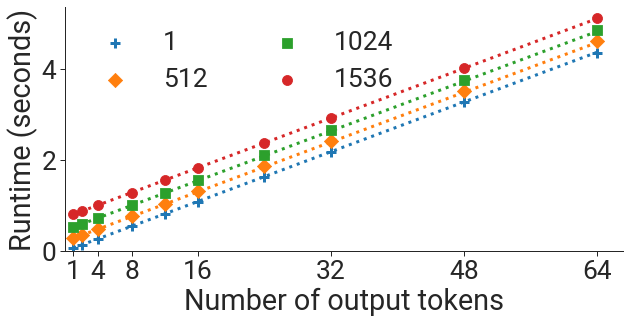

In [11]:
# Plot A100 runtimes on Megatron.
runtimes = megatron_runtimes
runtimes_per_output_token = megatron_runtimes_per_output_token
plot_per_model_runtimes(runtimes, 'openai_davinci', [1, 512, 1024, 1536],
                        scatter=True,
                        runtime_per_output_token=runtimes_per_output_token['openai_davinci'],
                        output_filename='../figures/runtime_vs_num_output_tokens/openai_davinci.pdf')
plot_per_model_runtimes(runtimes, 'ai21_j1_jumbo', [1, 512, 1024, 1536],
                        scatter=True,
                        runtime_per_output_token=runtimes_per_output_token['ai21_j1_jumbo'],
                        output_filename='../figures/runtime_vs_num_output_tokens/ai21_j1_jumbo.pdf')
plot_per_model_runtimes(runtimes, 'mt_nlg', [1, 512, 1024, 1536],
                        scatter=True,
                        runtime_per_output_token=runtimes_per_output_token['mt_nlg'],
                        output_filename='../figures/runtime_vs_num_output_tokens/mt_nlg.pdf')
plot_per_model_runtimes(runtimes, 'anthropic', [1, 512, 1024, 1536],
                        runtime_per_output_token=runtimes_per_output_token['anthropic'],
                        scatter=True, output_filename='../figures/runtime_vs_num_output_tokens/anthropic.pdf')
plot_per_model_runtimes(runtimes, 'bloom', [1, 512, 1024, 1536],
                        runtime_per_output_token=runtimes_per_output_token['bloom'],
                        scatter=True, output_filename='../figures/runtime_vs_num_output_tokens/bloom.pdf')
plot_per_model_runtimes(runtimes, 'opt_66b', [1, 512, 1024, 1536],
                        runtime_per_output_token=runtimes_per_output_token['opt_66b'],
                        scatter=True, output_filename='../figures/runtime_vs_num_output_tokens/opt_66b.pdf')
plot_per_model_runtimes(runtimes, 'yalm', [1, 512, 1024, 1536],
                        runtime_per_output_token=runtimes_per_output_token['yalm'],
                        scatter=True, output_filename='../figures/runtime_vs_num_output_tokens/yalm.pdf')

ai21_j1_large


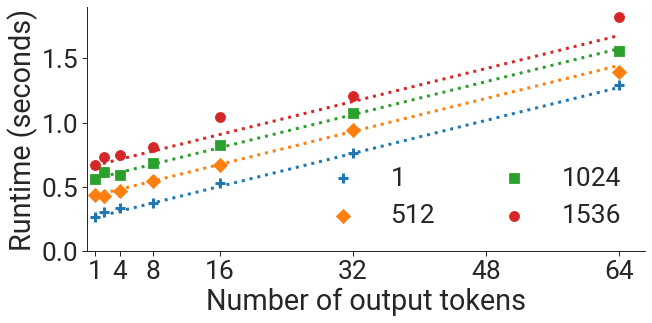

ai21_j1_grande


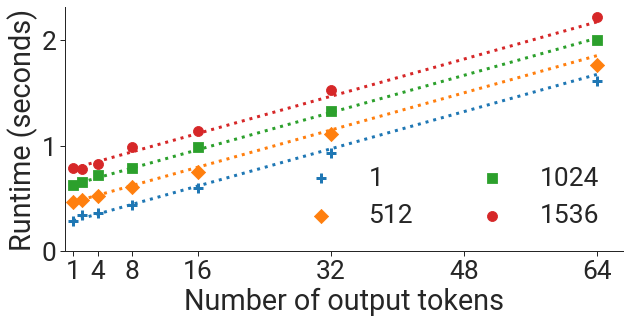

ai21_j1_jumbo


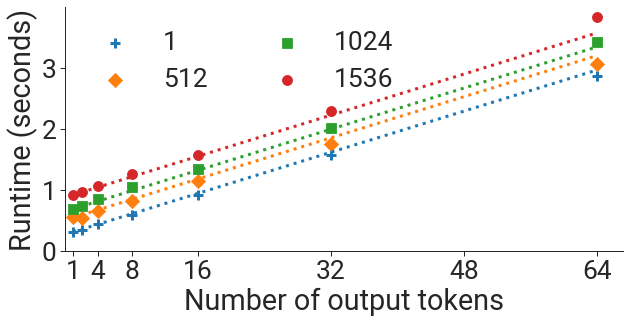

anthropic


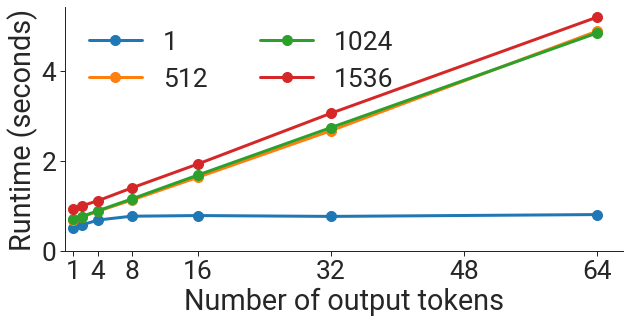

openai_text-curie-001


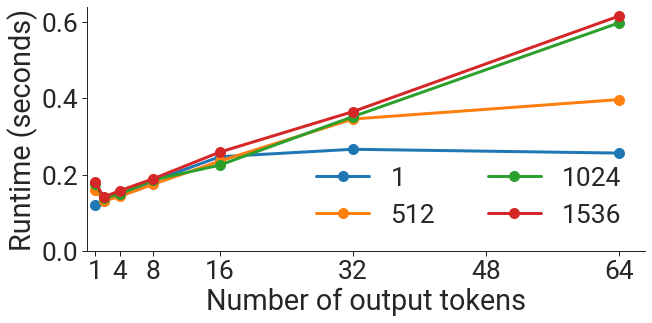

In [12]:
# Plot minimum black-box API runtimes.
runtimes = real_system_runtimes
runtimes_per_output_token = real_system_runtimes_per_output_token
plot_per_model_runtimes(runtimes, 'ai21_j1_large', [1, 512, 1024, 1536],
                        runtime_per_output_token=runtimes_per_output_token['ai21_j1_large'],
                        scatter=True, output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_large_v3.pdf')
plot_per_model_runtimes(runtimes, 'ai21_j1_grande', [1, 512, 1024, 1536],
                        runtime_per_output_token=runtimes_per_output_token['ai21_j1_grande'],
                        scatter=True, output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_grande_v3.pdf')
plot_per_model_runtimes(runtimes, 'ai21_j1_jumbo', [1, 512, 1024, 1536],
                        runtime_per_output_token=runtimes_per_output_token['ai21_j1_jumbo'],
                        scatter=True, output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_jumbo_v3.pdf')
plot_per_model_runtimes(runtimes, 'anthropic', [1, 512, 1024, 1536],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_anthropic_v3.pdf')
plot_per_model_runtimes(runtimes, 'openai_text-curie-001', [1, 512, 1024, 1536],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_openai_curie_v3.pdf')